In [68]:
from pandas import read_csv

In [69]:
data = read_csv('data/agg/BTC_agg_OI_FR.csv', parse_dates=['timestamp'])
data = data.set_index('timestamp')
data

,Agg Weighted FR,Agg OI
timestamp,,
2020-04-01,-0.039073,6.966046e+08
2020-04-02,0.006521,6.665020e+08
2020-04-03,-0.021530,6.837366e+08
2020-04-04,-0.008062,6.865173e+08
2020-04-05,0.001697,6.757367e+08
...,...,...
2023-12-27,0.029520,3.147515e+09
2023-12-28,0.030703,3.135693e+09
2023-12-29,0.019693,3.065951e+09


In [70]:
slope = 0.1485
initial_supply = 5e5

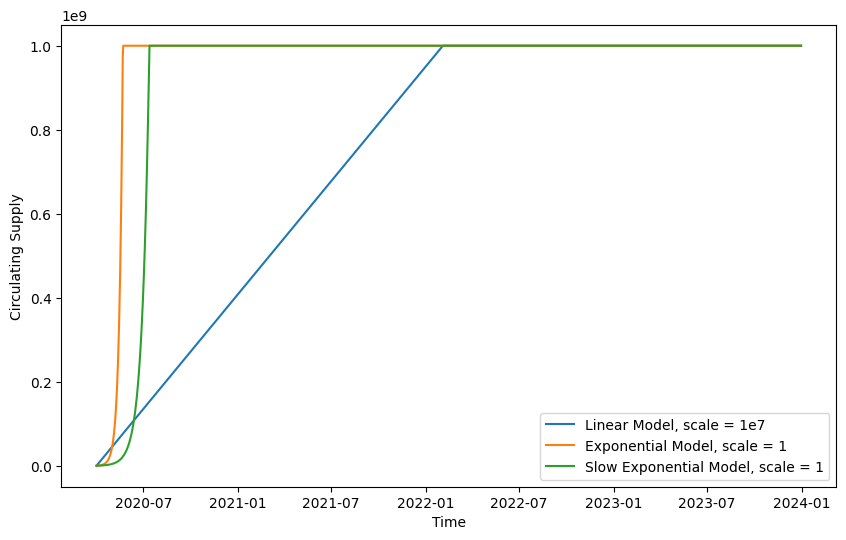

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def linear_model(x, scale):
    values = initial_supply + scale * slope * x
    return np.where(values < 1e9, values, 1e9)

def exponential_model(x, scale):
    values = initial_supply * np.exp(slope * scale * x)
    return np.where(values < 1e9, values, 1e9)

def slow_exponential_model(x, scale):
    values = initial_supply * np.exp(0.074 * scale * x)
    return np.where(values < 1e9, values, 1e9)

linear_supply = linear_model(np.arange(0, 1370, 1), 1e7)
exponential_supply = exponential_model(np.arange(0, 1370, 1), 1)
slow_exponential_supply = slow_exponential_model(np.arange(0, 1370, 1), 1)

plt.figure(figsize=(10, 6))
plt.plot(data.index, linear_supply, label='Linear Model, scale = 1e7')
plt.plot(data.index, exponential_supply, label='Exponential Model, scale = 1')
plt.plot(data.index, slow_exponential_supply, label='Slow Exponential Model, scale = 1')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Circulating Supply')
plt.show()


Position size set at 5% and 10% of OI

Return = Position size * Funding Rate

In [72]:
fund_data = data.copy()

fund_data['Pos Size 1'] = fund_data['Agg OI'] * 5e-2
fund_data['Pos Size 2'] = fund_data['Agg OI'] * 1e-1

fund_data['Return 1'] = fund_data[f'Pos Size 1'] * fund_data['Agg Weighted FR']
fund_data['Return 2'] = fund_data[f'Pos Size 2'] * fund_data['Agg Weighted FR']

In [73]:
fund_data

,Agg Weighted FR,Agg OI,Pos Size 1,Pos Size 2,Return 1,Return 2
timestamp,,,,,,
2020-04-01,-0.039073,6.966046e+08,3.483023e+07,69660457.8,-1.360906e+06,-2.721811e+06
2020-04-02,0.006521,6.665020e+08,3.332510e+07,66650201.5,2.172965e+05,4.345931e+05
2020-04-03,-0.021530,6.837366e+08,3.418683e+07,68373659.9,-7.360546e+05,-1.472109e+06
2020-04-04,-0.008062,6.865173e+08,3.432586e+07,68651725.1,-2.767300e+05,-5.534600e+05
2020-04-05,0.001697,6.757367e+08,3.378684e+07,67573670.9,5.733498e+04,1.146700e+05
...,...,...,...,...,...,...
2023-12-27,0.029520,3.147515e+09,1.573757e+08,314751489.1,4.645788e+06,9.291575e+06
2023-12-28,0.030703,3.135693e+09,1.567846e+08,313569257.4,4.813726e+06,9.627451e+06
2023-12-29,0.019693,3.065951e+09,1.532975e+08,306595056.5,3.018875e+06,6.037750e+06


Fees = Keep Rate * Position Size * fee

In [74]:
def calculate_profit(pos, kr, fee):
    '''
    args:
        pos - position size: 1 or 2
        kr - keep rate: 0.1, 0.2 or 0.5
        fee - fee value in percent
    '''
    fees = kr * fund_data[f'Pos Size {pos}'] * fee / 1e2
    return fund_data[f'Return {pos}'] - fees

keep rates: 0.1, 0.2, 0.5

| Agg   | Volume (Millions) | Taker | Maker |
|-------|-------------------|-------|-------|
| Vip 0 | < 10              | 0.06% | 0.02% |
| Vip 1 | 10 - 25           | 0.04% | 0.02% |
| Vip 2 | 25 - 50           | 0.04% | 0.02% |
| Vip 3 | 50 - 100          | 0.04% | 0.01% |
| Vip 4 | 100 - 250         | 0.03% | 0.01% |
| Vip 5 | > 250             | 0.03% | 0.01% |

In [75]:
test = calculate_profit(1, 0.1, 0.06)
test

timestamp
2020-04-01   -1.362995e+06
2020-04-02    2.152970e+05
2020-04-03   -7.381058e+05
2020-04-04   -2.787896e+05
2020-04-05    5.530777e+04
                  ...     
2023-12-27    4.636345e+06
2023-12-28    4.804319e+06
2023-12-29    3.009677e+06
2023-12-30    3.870626e+06
2023-12-31    4.985716e+06
Length: 1370, dtype: float64

In [76]:
test.sum()

2330098531.161789

In [77]:
test.mean()

1700801.8475633496

<AxesSubplot: xlabel='timestamp'>

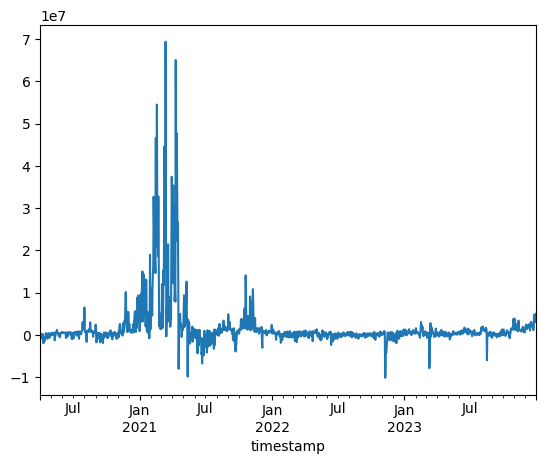

In [78]:
test.plot()